# Singularly Perturbed Equations

## Boundary layers
Consider the linear 2-point boundary value problem
$$ \begin{array}{c}a u'(x) = \kappa u''(x) + \psi(x), \\
 u(0) = \alpha, \quad u(1) = \beta. \end{array}$$
    If $a$ is small relative to $\kappa$􏰭, then this problem is easy to solve.  Now, suppose $a$ is large relative to $\kappa$.  Here, we introduce a parameter $\epsilon = \frac{\kappa}{a}$, and rewrite the above equation in the form
$$ \epsilon u''(x) - u'(x) = f(x).$$
Then taking $a$ large relative to $\kappa$ corresponds to the case $\epsilon \ll 􏰱1$.􏰭 

__Example__:
Considering
$$ \begin{array}{c}\epsilon u''(x) - u'(x) = f(x), \\
 u(0) = \alpha, \quad u(1) = \beta. \end{array}$$
Here, $\alpha = 1$, $\beta=3$, and $f(x) = -1$.  In this case the exact solution (why?) is
$$ u(x) = \alpha + x + \beta + (\beta - \alpha -1)\left(\frac{e^{x/\epsilon} -1}{e^{1/\epsilon}-1}\right) $$


In [1]:
#%matplotlib notebook
%matplotlib inline

# environment setting, before any codes
import numpy as np
import scipy.linalg as slinalg

import matplotlib.pyplot as plt

from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
from IPython.display import clear_output, display

In [55]:
def exact_fun(x, alpha, beta, epsilon):
    return alpha + x + (beta - alpha - 1)*((np.exp(x/epsilon)-1)/(np.exp(1/epsilon)-1))

alpha = 1
beta = 3
epsilon = 0.002

number = 101
def draw_fun(number, alpha, beta, epsilon):
    x = np.linspace(0, 1, number)
    y = exact_fun(x, alpha, beta, epsilon)
    plt.plot(x,y,'r',linewidth=2)
    return epsilon
#draw_fun(number, alpha, beta, epsilon)
w = interactive(draw_fun, number=fixed(number), alpha=fixed(alpha), beta=fixed(beta),\
                epsilon=widgets.FloatSlider(min=0.01,max=1.00,step=0.01, value=1.00, description='$\epsilon:$',))
display(w)

interactive(children=(FloatSlider(value=1.0, description='$\\epsilon:$', max=1.0, min=0.01, step=0.01), Output()), _dom_classes=('widget-interact',))

Note that as $\epsilon \rightarrow 0$􏰫 the solution tends toward a discontinuous function that jumps to the value $\beta$ at the last possible moment.  This region of rapid transition is called the _boundary layer_ and it can be shown that for this problem the width of this layer is $\mathcal{O}(\epsilon)$ as $\epsilon \rightarrow 0$.

The above equation with $0 < \epsilon \ll 1$ is called a _singularly perturbed equation_. It is a small perturbation of equation $-u'(x) = f(x)$, but this small perturbation completely changes the character of the equation (from a first order to a second order equation). Typically any differential equation having a small parameter multiplying the highest order derivative will give a singular perturbation problem.

### Finite Difference Methods
This _singularly perturbed equation_ can be discretized to second order by
$$ \epsilon\left(\frac{U_{i+1} - 2U_i + U_{i-1}}{h^2}\right) - \left(\frac{U_{i+1} - U_{i-1}}{2h}\right) = f_i, \qquad i = 1,\ldots, m,$$
with $U_0 = \alpha$ and $U_{m+1} = \beta$.  This gives the linear system $AU = F$, where $U$ is the vector of unknowns $U = [U_0, U_1, \ldots, U_m, U_{m+1}]^T$, $A$ is the tridiagonal matrix
$$
    A = \frac{1}{h^2}\left[\begin{array}{cccccccc}
    h^2  &  0 &   &    &   &    & & \\
    \epsilon + h/2  & -2\epsilon &  \epsilon - h/2 &    &   &    & &\\
       &  \epsilon + h/2  & -2\epsilon &  \epsilon - h/2 &   &    & &\\ 
       &    &  \epsilon + h/2  & -2\epsilon &  \epsilon - h/2 &    & &\\
       &    & & \ddots & \ddots &\ddots & &\\
       &    &    &    & \epsilon + h/2  & -2\epsilon &  \epsilon - h/2  &\\
       &    &    &    &   &  \epsilon + h/2  & -2\epsilon &  \epsilon - h/2 \\
       &    &    &    &   &   &  0 & h^2\end{array}\right],
           \quad
   \text{and}\quad F = \left[\begin{array}{c} \alpha \\ f_1\\ f_2 \\ f_3 \\ \vdots \\ f_{m-1} \\ f_m \\ \beta\end{array}\right]. 
$$

In [65]:
def generate_grid(left, right, m):
    h = (right - left)/(m+1)
    x = np.zeros(m+2)
    for j in range(m+2):
        x[j] = j*h
    return  x, h

def generate_A_interior(epsilon, h, m):
    A = np.zeros([m+2, m+2])
    for i in range(1,m+1):
        A[i, i-1] = epsilon + h/2.
        A[i, i] = -2*epsilon
        A[i, i+1] = epsilon - h/2
    #A[1:m+1,1:m+1] = - 2*np.eye(m, m) 
    #A[ += np.eye(m+2, m+2, -1) + np.eye(m+2, m+2, 1)
    return A/h**2

def generate_F_interior(h, m, x, fun):
    F = np.zeros(m+2)
    for i in range(1,m+1):
        F[i] = fun(x[i])
    return F

def Dirichlet_bc(A, F, alpha, beta, h, fun):
    A[0,0] = 1
    A[-1,-1] = 1
    F[0] = alpha
    F[-1] = beta
    return A, F

def fun(x):
    return -1

def FDM_BVP(m, left, right, alpha, beta, epsilon, bc, fun, exact_fun):
    # generate the grid
    x, h = generate_grid(left, right, m)
    #
    U = np.zeros(m+2)
    # 
    A = generate_A_interior(epsilon, h, m)
    #print (A)
    F = generate_F_interior(h, m, x, fun)
    #print (F)
    # bc
    A, F = bc(A, F, alpha, beta, h, fun)
    #print (A)
    #print (F)
    U = np.linalg.solve(A, F)
    
    u = exact_fun(x, alpha, beta, epsilon)
    return np.max(np.abs(U-u)), x, U, u

max norm error: 6.96e-01


0.01

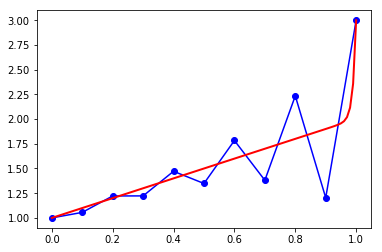

In [66]:
alpha = 1
beta = 3
epsilon = 0.01
error, x, U, u = FDM_BVP(9, 0, 1, alpha, beta, epsilon, Dirichlet_bc, fun, exact_fun)

print ("max norm error: %7.2e" % error )
# let us plot the approximation solution in blue, and the exact solution in red
#plt.plot(x, u, 'ro-')
plt.plot(x, U, 'bo-')
number = 101
draw_fun(number, alpha, beta, epsilon)

In [71]:
def draw_appximation(m, epsilon):
    error, x, U, u = FDM_BVP(m, 0, 1, alpha, beta, epsilon, Dirichlet_bc, fun, exact_fun)
    print ("max norm error: %7.2e" % error )
    # let us plot the approximation solution in blue, and the exact solution in red
    #plt.plot(x, u, 'ro-')
    plt.plot(x, U, 'bo-')
    number = 101
    draw_fun(number, alpha, beta, epsilon)
    
#draw_appximation(9, 0.01)
w = interactive(draw_appximation, m=widgets.IntSlider(min=9,max=2000,step=10, value=9, description='$m:$',),\
                epsilon=widgets.FloatSlider(min=0.01,max=1.00,step=0.01, value=1.00, description='$\epsilon:$',))
display(w)

interactive(children=(IntSlider(value=9, description='$m:$', max=2000, min=9, step=10), FloatSlider(value=1.0, description='$\\epsilon:$', max=1.0, min=0.01, step=0.01), Output()), _dom_classes=('widget-interact',))

In [68]:
levels = 8
m = np.array([9, 19, 39, 79, 159, 319, 639, 1279], int)
err_max = np.zeros(levels)
print ('   h      max error   order  ')
for i in range (levels):
    err_max[i],_,_,_ = FDM_BVP(m[i], 0, 1, alpha, beta, epsilon, Dirichlet_bc, fun, exact_fun)
    if (i == 0):
        print ('%7.2e  %7.2e' % (1/(m[i]+1), err_max[i]))
    else:
        print ('%7.2e  %7.2e    %4.2f' % (1/(m[i]+1), err_max[i], \
                                        np.log(err_max[i-1]/err_max[i])/np.log((m[i]+1)/(m[i-1]+1))))

   h      max error   order  
1.00e-01  6.96e-01
5.00e-02  4.35e-01    0.68
2.50e-02  1.93e-01    1.17
1.25e-02  5.57e-02    1.79
6.25e-03  1.21e-02    2.20
3.13e-03  3.02e-03    2.01
1.56e-03  7.49e-04    2.01
7.81e-04  1.87e-04    2.00


## Interior layers